# **Redes Neuronales Profundas Ortogonales (OrthDNNs)**
>**Universidad Nacional de Colombia**
>
>**Álgebra Lineal Numérica - 2025 I**
>
>*Mateo Sebastian Ortiz Higuera*

## **Introducción**

En el presente cuaderno exploraremos el papel de la ortogonalidad dentro de las redes neuronales profundas (OrthDNNs) resaltando cómo esta restricción geométrica ofrece una vía elegante para mitigar problemas numéricos clásicos (gradientes explosivos / desvanecientes) y, al mismo tiempo, para fomentar la generalización al “decorrelacionar” las representaciones intermedias del modelo. Partiremos de la motivación teórica expuesta por S. Li et al. [1] y la conectaremos con herramientas de Álgebra Lineal Numérica, particularmente con transformaciones de Householder y descomposiciones QR, que constituyen el eje central de nuestras implementaciones. Después realizaremos diversos experimentos en donde mostraremos el comportamiento de estas redes sobre el problema de clasificación de imágenes MNIST, seguido de un análisis y conclusiones sobre los resultados obtenidos. 

### **Objetivos**
*  Explicar las redes neuronales profundas ortogonales sin entrar a revisar el fundamento teórico fuerte que hay detrás de ellas, que se escapa de los objetivos y temas del curso. En su lugar, tratar de entender qué son y, a través de ejemplos, por qué podrían ser buenos en problemas de clasificación.
*  Realizar experimentos en donde se revise la capacidad de generalización y otros aspectos numéricos que puedan ser de interés, como el tiempo de cómputo, la estabilidad numérica, etc. 

### **Entendiendo las redes neuronales**

Para entender las Redes Neuronales Profundas Ortogonales primero entendamos las Redes Neuronales Superficiales/Profundas. 

Matemáticamente, una *red neuronal superficial* es una familia de modelos no lineales parametrizados por unos pesos $\phi_i,w_{i,j} \in \mathbb{R}$ y un bias $b_i\in \mathbb{R}$, de la forma

$$F(\mathbf{x}) = \phi_0 + \sum_{i=1}^n \phi_i a\left[ \sum_{j=1}^d w_{i,j} x_j + b_i\right]  $$

en donde la red neuronal tiene $n$ neuronas o unidades ocultas, $\mathbf{x}\in\mathbb{R}^{d}$ y $a$ es una función de activación que induce no linealidad. Por ejemplo, supongamos que la red neuronal tiene como entrada tres valores, tiene $3$ unidades ocultas y  predice dos valores, podemos notar $h_i=a(w_{i1}x_1 + w_{i2}x_2 + w_{i3}x_3 + b_i)$ :

<img src="image01.jpg" alt="red neuronal superficial con "  style="width:250px; margin:auto"/>
\begin{align}
    y_1 &= \phi_0 + \phi_1 h_1 + \phi_2 h_2 + \phi_3 h_3 \\
    y_2 &= \phi_0 + \phi_1 h_1 + \phi_2 h_2 + \phi_3 h_3 \\
    \mathbf{y} &= \Phi_0 + \Phi_1 h_1 + \Phi_2 h_2 + \Phi_3 h_3 
\end{align}

en donde $\Phi_i = \begin{bmatrix} \phi_{1,i} \\ \phi_{2,i} \end{bmatrix}$, $i=0,1,2,3$.

Podemos extender esta noción añadiendo más capas, así tenemos una *red neuronal profunda*; básicamente tenemos una composición de redes neuronales superficiales. Nuestros nuevos pesos serán matrices $W_i\in \mathbb{R}^{\ell\times d}$ y los bias vectores $b_i\in \mathbb{R}^{d}$, en donde $i$ es la capa actual, $\ell$ es el número de neuronas de la capa anterior y $d$ es el número de neuronas de la capa actual. Dicha familia se puede ver de la siguiente forma:

$$ F(\mathbf{x}) = b_k + W_k a\left[ b_{k-1} + W_{k-1} a\left[\dotsb b_2 + W_2 a\left[b_1 + W_1 \mathbf{x}  \right]  \right] \dotsb  \right]$$

o recursivamente, definiendo $h_i = \begin{cases}W_i a\left[b_{i-1} + W_{i-1}h_{i-1} \right], \text{ si }i>2\\ W_2 a\left[b_1 + W_1 \mathbf{x}\right], \text{ si }i=2\end{cases}$, tenemos

$$ F(\mathbf{x}) = W_k h_k + b_k $$

Tomemos el ejemplo anterior y agreguemos dos capas ocultas más, de la forma:

<img src="image02.jpg" alt="red neuronal superficial con "  style="width:400px; margin:auto"/>

así tenemos $W_4\in \mathbb{R}^{2\times 4}$, $b_4\in \mathbb{R}^{2}$, $W_3\in \mathbb{R}^{4\times 3}$, $b_3\in \mathbb{R}^{4}$, $W_2\in \mathbb{R}^{3\times 5}$, $b_2\in \mathbb{R}^{3}$, $W_1\in \mathbb{R}^{3\times 5}$ y $b_1\in \mathbb{R}^{5}$. Y la función sería:

$$ \mathbf{y}= W_4 h_4 + b_4 $$

En el aprendizaje automático, optimizamos una función de pérdida $\mathcal{L}$ para encontrar los valores de $W_i$ y $b_i$ para que el modelo pueda predecir con muestras no vistas anteriormente. 

### **Un pequeño ejemplo**

En el resto del notebook vamos a trabajar principalmente con el siguiente problema: supongamos que queremos crear una red neuronal que quiere clasificar imágenes del dataset MNIST (imágenes de números escritos a mano). En donde cada imágen tiene un tamaño de $28\times 28$ pixeles, que equivalen a 784 pixeles. Podemos proponer una primer red neuronal profunda que tenga como entrada los 784 pixeles, con dos capas ocultas y una capa final con 10 salidas, que representan las probabilidades para cada una de las clases (los dígitos del 0 al 9).

<img src="mnist.jpg" alt="Muestra del Dataset de MNIST "  style="width:400px; margin:auto"/>

El grafo computacional referente a esta propuesta sería podría ser algo así:

<img src="image03.jpg" alt="Grafo computacional con 4 capas"  style="width:400px; margin:auto"/>

En este modelo, la primera capa representa cada pixel de la imagen, las dos capas ocultas extraen información de los pixeles (patrones de las imágenes) y la última funciona para predecir el digito de la imagen. Entrenamos el modelo para ajustar los valores de las matrices de pesos $W_1,W_2 $ y $ W_3$ para que el modelo aprenda a representar y predecir cada dígito.

Se puede ver este ejemplo [aquí](https://adamharley.com/nn_vis/mlp/2d.html).


Debe notarse que las imágenes de, por ejemplo, el dígito 2, van a encender las mismas neuronas a lo largo de las capas. Ya que los valores de la entrada serán muy similares y así debería ser a lo largo del cómputo del grafo computacional. Esto da sentido las redes neuronales profundas ortogonales, como veremos a continuación; si conseguimos que los valores de las matrices de pesos $W_i$ logren preservar las relaciones espaciales y los patrones detectados a través de las capas, entonces estos contribuyen a mejorar las predicciones de la red neuronal.

### **Redes Neuronales Profundas Ortogonales**

Cuando nos referimos a las *redes neuronales profundas ortogonales* hablamos de redes neuronales profundas cuyas matrices de pesos $W_i$ son ortogonales. Esta propiedad garantiza que cada transformación lineal entre capas preserva las distancias y ángulos, es decir una isometría.
Generalizando lo observado en un ejemplo anterior, mantener isometrías entre capas permite que los datos que pertenecen a una misma clase (por ejemplo, imágenes del dígito '3') permanezcan agrupados a lo largo de la red. Esto significa que las representaciones internas de ejemplos similares se mantendrán "cerca" unas de otras, incluso después de múltiples transformaciones entre capas. De manera análoga, las muestras de diferentes clases (como '3' y '8') seguirán estando separadas.

Esto es beneficioso para la tarea de clasificación, ya que facilita que el modelo pueda aprender fronteras de decisión claras entre clases. Por el contrario, si las matrices de pesos no son ortogonales, las transformaciones pueden distorsionar el espacio de representación: los puntos cercanos pueden alejarse, y los distantes pueden acercarse. Esto podría llevar a que el modelo confunda clases distintas y degrade su capacidad de generalización, por ejemplo, podría confundir un '3' y clasificarlo como un '8'.

Algo que también debemos notar es que al inducir no linealidad, estamos partiendo el hiperplano de muestras. Más adelante observaremos que podemos mantener isometrías locales con un factor de expansión $\delta$, que mantendrán las distancias en base a dicho factor en las partes lineales de nuestro modelo.

<img src="image04.jpg" alt="Representación de una transformación de un espacio a otro " style="width:750px; margin:auto"/>

En la imagen anterior podemos ver más claramente el ejemplo, cada punto de distinto color representa una muestra de alguna de las clases (0,1,2,...,9). Algunos estarán más cerca al resto ya que pueden tener algunas formas similares (1 y 7, o 4 y 9). Y al aplicarse la transformación con $W_1$ ortogonal, los valores preservan estas relaciones de cercanía. Siguiendo con estas transformaciones, en la capa final de predicción, vamos a tener que el modelo puede llegar a separar, acotar y predecir cada categoría de mejor forma.

### **Entrenamiento de los Modelos y algunos problemas asociados**

Ahora bien, todo lo descrito anteriormente ocurre cuando ya tenemos un modelo con valores $W_i$ y $b_i$ fijos, es decir, ya entrenado. Sin embargo, el objetivo en el aprendizaje automático es hacer que la red neuronal "aprenda" los mejores valores que le permitan al modelo generalizar, utilizando métodos de optimización. En particular, el método de gradiente en descenso es el método utilizado para entrenar redes neuronales, dada una función de pérdida $\mathcal{L}= g(f_\theta(x),y)$ seleccionada para nuestro problema, actualizamos nuestros valores $\theta:=\{W_i, b_i: i=0,1,...,n\}$ acercándonos a un mínimo local derivando dicha función de pérdida:

$$ \theta_{t+1}\rightarrow \theta_t - \alpha \frac{\partial \mathcal{L}}{\partial \theta} $$

en donde $\alpha$ es llamado learning-rate y es un hiperparámetro que indica el peso con el que el gradiente se mueve. El algoritmo utilizado para hacer esto es el llamado *Back propagation*, en donde actualizamos los valores utilizando el método de la cadena (recordemos que una red neuronal es una composición de muchas funciones que inducen no linealidad a funciones lineales). De aquí tenemos distintos problemas que podemos tocar, por ejemplo, ¿cómo garantizar que las derivadas no exploten o se desvanezcan?. Y es que recordemos que todo esto lo realizamos en un computador y al ir acumulando truncamiento al paso de las capas, podemos llegar a un 0 de máquina en donde el resto de las derivadas se irán a 0 o podemos llegar a un valor grande en donde hace que el resto de derivadas se hagan extremadamente grandes. Afortunadamente, esto lo podemos controlar inicializando los valores $\theta$ de alguna forma que logre mitigar esto.

<img src="image05.jpg" alt="Explosión y desvanecimiento en un paso backward"  style="width:400px; margin:auto"/>

En particular, una forma de controlar esto es inicianizándolas y ajustándolas para que sean ortogonales a lo largo del entrenamiento, ya que la ortogonalidad provee estabilidad numérica.

Otro problema común es el sobreajustamiento a los datos de entrenamiento, y es que el modelo podría aprender a predecir muy bien los datos de entrenamiento pero no los datos de prueba. Esto puede ser visto como si el modelo se aprendiera de memoria los datos de entrenamiento tan bien que no sabe predecir nada más que eso. Entre los métodos para controlar esto está el de regularización, que consiste en penalizar algunos parámetros del modelo, en general suelen ser los valores de los pesos $W_i$, de esta forma el modelo ya no aprende los parámetros que se ajusten mejor a los datos. Utilizando regularización para inducir a pesos ortogonales estamos solucionando este problema.

## **Preliminares y algoritmos**

Primero carguemos paquetes necesarios y definamos algunos algoritmos necesarios para el desarrollo del cuaderno.

In [1]:
using LinearAlgebra
using Statistics
using Random
using Plots

### *Algoritmo de Householder*

Utilizaremos el algoritmo de Householder para desarrollar matrices Ortogonales. Los algoritmos son los mismos implementados en clase, 

In [2]:
## Funciones implementadas en los cuadernos de clase por el profesor ##

function house(x)
    n = size(x,1) #(m,n)
    s = x[2:n]'x[2:n]
    v = [1; x[2:n]]

    if s == 0
        β = 0
    else
        mu = sqrt(x[1]^2 + s)
        if x[1] <= 0
            v[1] = x[1] - mu
        else
            v[1] = -s /(x[1]+mu)
        end
        β = 2((v[1])^2)/(s + (v[1])^2)
        v=v/v[1]
    end
    return v, β
end

function QFA(A)
    Q = UniformScaling(1)
    m,n = size(A)
    for j = 1:n
        v,β = house(A[j:m,j])
        v1 = zeros(j-1,1)
        v = [v1;v]
        Qj = UniformScaling(1)-β*v*v'
        Q = Q*Qj
        A=Qj*A;
    end
    return Q, A
end

function VβHouse(A)
    m,n = size(A)
    β   = zeros(n,1)
    Y   = zeros(m,n)

    Am  = copy(A)

    # Primera actualización
    v1,β[1] = house(Am[:,1])
    Y[:,1]  = v1
    W       = -β[1]*v1
    Am      = ( UniformScaling(1) - β[1]*v1*v1')Am

    #De ahi para adelante
    for j = 2:n
        v1,β[j] = house(Am[j:m,j])
        Y[:,j]  = [ zeros(j-1,1) ; v1 ]
        z       = -β[j]*(UniformScaling(1)+W*Y[:,1:j-1]')*Y[:,j]
        W       = [ W z ]
        Am[j:m,j:n] = ( UniformScaling(1) - β[j]*v1*v1')Am[j:m,j:n]
    end


    return Y,W,Am
end

VβHouse (generic function with 1 method)

### *Ejemplo*

Veamos un pequeño ejemplo de la intuición descrita en la introducción. Creemos una matriz $A$, con ella generamos una matriz ortogonal $Q$ que serviría como matriz de pesos en la red neuronal. Después definimos dos vectores que podrían ser muestras cercanas de una misma categoría. Finalmente calculemos las distancias entre los vectores antes/después de las transformaciones.

In [26]:
A = rand(5,5)

Q,R = QFA(A)
x = rand(5)
y = x + 0.1*rand(5)

println("Distancia entre los vectores en el espacio original:",norm(x - y))
println("Distancia entre los vectores tras la transformación ortogonal:",norm(x'*Q - y'*Q))
println("Distancia entre los vectores tras la transformación no ortogonal:",norm(x'*A - y'*A))

Distancia entre los vectores en el espacio original:0.07875658102039006
Distancia entre los vectores tras la transformación ortogonal:0.07875658102039024
Distancia entre los vectores tras la transformación no ortogonal:0.2017897522729214


Se puede observar que la transformación ortogonal preserva la distancia entre los vectores, mientras que la transformación con la matriz no ortogonal no lo hace.

A continuación veamos el siguiente ejemplo visual de esto, para practicidad tomemos muestras tres muestras de dos dimensiones.

In [19]:
## Código generado por DeepSeek ##

Random.seed!(8)
    
# Clase 1: Vectores alrededor del punto (3, 2)
centro1 = [3, 2]
clase1 = [centro1 + 0.5 * randn(2) for _ in 1:10]
    
# Clase 2: Vectores alrededor del punto (-2, 2)
centro2 = [-2, 2]
clase2 = [centro2 + 0.5 * randn(2) for _ in 1:10]
    
# Clase 3: Vectores alrededor del punto (1, -2)
centro3 = [1, -2]
clase3 = [centro3 + 0.5 * randn(2) for _ in 1:10]


muestra = vcat(clase1,clase2,clase3)

display(clase1[1])
display(clase2[1])
display(clase3[1])

2-element Vector{Float64}:
 2.797228856566152
 1.985191180510149

2-element Vector{Float64}:
 -1.77291269756537
  1.9189271578902476

2-element Vector{Float64}:
  0.7798157691386695
 -1.605586621312143

Ahora creemos algunas matrices ortogonales para realizar las distintas transformaciones.

In [33]:
pesos = Matrix{Float64}[]
deltas = Float64[]
for _ in 1:5
    A = (randn(2,2)*2) .- 1
    Q,_ = QFA(A)
    push!(pesos,Q)
    delta = randn()*1.35
    push!(deltas,delta)
end

Ahora simulemos la propagación hacia adelante que realiza la red neuronal. Es decir, las transformaciones.

In [34]:
transformaciones = [[] for _ in 1:6]
transformaciones[1] = copy(muestra)
for i in 1:5
    vectores_capa = []
    for c in transformaciones[i]
        x = (pesos[i]*c)*deltas[i]
        push!(vectores_capa, x)
    end
    transformaciones[i+1] = vectores_capa
end

Grafiquemos las transformaciones:

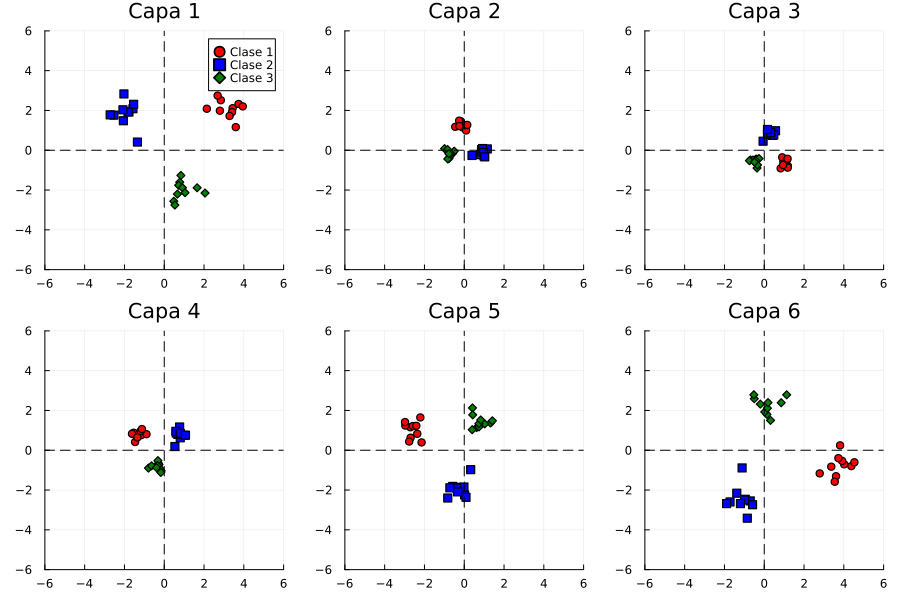

In [35]:
## Código generado por Claude.ai ##

# Crear una figura con 6 subplots
plot(layout=(2,3), size=(900, 600), aspect_ratio=:equal, grid=true, legend=:topright)

# Graficar cada transformación en su propio subplot
for i in 1:6
    # Datos para la capa actual
    capa = transformaciones[i]
    
    # Graficar cada clase con diferente color y marcador
    scatter!([p[1] for p in capa[1:10]], [p[2] for p in capa[1:10]], 
            color=:red, label=i==1 ? "Clase 1" : "", 
            markershape=:circle, subplot=i)
    scatter!([p[1] for p in capa[11:20]], [p[2] for p in capa[11:20]], 
            color=:blue, label=i==1 ? "Clase 2" : "", 
            markershape=:square, subplot=i)
    scatter!([p[1] for p in capa[21:30]], [p[2] for p in capa[21:30]], 
            color=:green, label=i==1 ? "Clase 3" : "", 
            markershape=:diamond, subplot=i)
    
    # Añadir ejes y título
    hline!([0], color=:black, linestyle=:dash, label="", subplot=i)
    vline!([0], color=:black, linestyle=:dash, label="", subplot=i)
    plot!(title="Capa $i", subplot=i)
    
    # Ajustar límites de los ejes
    xlims!(subplot=i, (-6, 6))
    ylims!(subplot=i, (-6, 6))
end

# Mostrar el plot final
plot!()

Lo que podemos visualizar es la simulación de la $\delta$-isometría local a lo largo de las capas, podemos ver como las muestras en las capas 2,3 y 4 se retraen y después, en las capas 5 y 6 vuelven a expandirse, todo sin perder la relación de distancias entre las muestras.

## **Aplicación y Experimentos**

### Construcción del modelo 
Para los experimentos vamos a cargar una librería para construir redes neuronales, ya que no es el objetivo de este cuaderno implementar uno desde cero.

In [3]:
using Flux, MLDatasets

In [4]:
Flux.DataLoader

MLUtils.DataLoader

Ahora carguemos el dataset de MNIST

In [5]:
# Cargar el dataset
train_x, train_y = MLDatasets.MNIST.traindata(Float32)
test_x, test_y = MLDatasets.MNIST.testdata(Float32)

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\mateo\.julia\packages\MLDatasets\0MkOE\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\mateo\.julia\packages\MLDatasets\0MkOE\src\datasets\vision\mnist.jl:195


(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [6]:
# Preparación de datos para convoluciones
train_x = reshape(train_x, 28, 28, 1, :)
test_x = reshape(test_x, 28, 28, 1, :)

# One-hot encoding de etiquetas (0–9 => 1–10)
train_y = Flux.onehotbatch(train_y .+ 1, 1:10)
test_y = Flux.onehotbatch(test_y .+ 1, 1:10)

# Crear batches
train_loader = Flux.DataLoader((train_x, train_y), batchsize=128, shuffle=true)
test_loader = Flux.DataLoader((test_x, test_y), batchsize=128)

79-element DataLoader(::Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=128)
  with first element:
  (28×28×1×128 Array{Float32, 4}, 10×128 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Primero inicializamos las capas con pesos ortogonales:

In [7]:
## Código generado parcialmente por DeepSeek como parte de una extensión a una implementación hecha por mí ##


# Construimos una matriz ortogonal utilizando el método de Householder implementado anteriormente
function orthogonal_matrix(rows::Int, cols::Int)
    if rows ≥ cols                # caso “alto”: m ≥ n  → usa tu VβHouse tal cual
        A = randn(Float32, rows, cols) * √2f0
        Y, W, _ = VβHouse(A)
        Q = UniformScaling(1) + W*Y'
        return Q[:, 1:cols]       # (rows × cols) con columnas ortonormales
    else                          # caso “ancho”: m < n
        # construimos primero columnas ortonormales de tamaño `rows`
        A = randn(Float32, cols, rows) * √2f0     # ahora m' ≥ n'
        Y, W, _ = VβHouse(A)
        Q = UniformScaling(1) + W*Y'
        Q = Q[:, 1:rows]          # (cols × rows) con columnas ortonormales
        return Q'                 # transponemos → (rows × cols) con filas ortonormales
    end
end

# Construimos una capa inicializando los pesos con los valores ortogonales
function OrthogonalDense(in_dim, out_dim; σ=Flux.relu)
    Q = orthogonal_matrix(out_dim, in_dim)
    b = zeros(out_dim)
    layer = Dense(Q, b, σ)
    return layer
end

OrthogonalDense (generic function with 1 method)

Ahora, creemos una función que retorne un modelo con 7 capas:

In [8]:
# Creamos la red neuronal
function createModel()
    model = Chain(
        Flux.flatten,
        OrthogonalDense(784,256),
        OrthogonalDense(256,128),
        OrthogonalDense(128,128),
        OrthogonalDense(128,64),
        OrthogonalDense(64,64),
        OrthogonalDense(64,32),
        OrthogonalDense(32,10),
        softmax
    )
    return model
end


createModel (generic function with 1 method)

Para forzar la ortogonalidad a través del entrenamiento podemos penalizar la función de pérdida forzándola a obtener matrices ortogonales, es decir, implementar una regularización ortogonal a la función de pérdida:

$$ \mathcal{L}(\theta) = \mathcal{L}(\theta) + \lambda \sum_{i=1}^n\| W_i^T W_i =I\|_F^2 $$

Así tenemos:

In [9]:
## Código generado parcialmente por DeepSeek como parte de una extensión a una implementación hecha por mí ##

function orth_loss(W)
    if ndims(W) == 2  # Capas Dense
        return sum(abs2, W' * W - I(size(W, 2)))
    else  # Capas Conv: reshape a matriz
        W_reshaped = reshape(W, :, size(W, 4))
        return sum(abs2, W_reshaped' * W_reshaped - I(size(W_reshaped, 2)))
    end
end

orth_loss (generic function with 1 method)

Y la función de pérdida, que en este caso utilizamos entropía cruzada, sería:

In [10]:
function total_loss(x, y, λ, model, ps)
    ce_loss = Flux.crossentropy(model(x), y)
    if λ == 0
        return ce_loss
    end
    reg_loss = sum(orth_loss, ps)
    return ce_loss + λ * reg_loss
end

total_loss (generic function with 1 method)

Finalmente implementemos la métrica de evaluación, el cual será accuracy:

In [11]:
import Flux: onecold

function accuracy(data_loader, model)
    correct = 0
    total = 0
    for (x, y) in data_loader
        ŷ = model(x)
        correct += sum(onecold(ŷ) .== onecold(y))
        total += size(x, 4)
    end
    return correct / total
end

accuracy (generic function with 1 method)

Con esto programemos una función que cree y entrene un modelo:

In [33]:
## Código generado parcialmente por DeepSeek como parte de una extensión a una implementación hecha por mí ##

function experimento(λ = 1e-4)
    opt = Flux.Optimise.Adam(0.001) 
   
   # Métricas de aprendizaje
    losses = Float32[]
    accs = Float32[]
    times = Float32[]
    
    # Métricas numéricas (por capa ortogonal)
    orth_errors = Vector{Float32}[]  # Para cada capa en cada época
    cond_numbers = Vector{Float32}[]

    modelo = createModel()
    ps = Flux.params(modelo)

    # Obtener capas ortogonales
    orth_layers = [layer for layer in Flux.modules(modelo) if typeof(layer) <: Dense]
    
    # Loop de entrenamiento
    for epoch in 1:25
        epoch_loss = 0.0
        epoch_time = 0.0
        for (x, y) in train_loader
            t_start = time()
            gs = gradient(ps) do
                total_loss(x, y, λ, modelo, ps)
            end
            Flux.update!(opt, ps, gs)
            epoch_time += Float32(time() - t_start)
            epoch_loss += total_loss(x,y,λ,modelo,ps)
        end
        # Cálculo de métricas numéricas (tras la época)
        push!(orth_errors, Float32[norm(layer.weight' * layer.weight - I, 2) for layer in orth_layers])
        push!(cond_numbers, Float32[cond(layer.weight) for layer in orth_layers])
        
        acc = accuracy(test_loader, modelo)
        push!(losses, epoch_loss / length(train_loader))
        push!(accs, acc)
        push!(times, epoch_time)
        println("Epoch $epoch - Loss: $(losses[end]) - Accuracy: $(accs[end]) - Time Elapsed: $(times[end])")
    end
    return modelo, losses, accs, times, orth_errors, cond_numbers
end

experimento (generic function with 2 methods)

### Análisis del Aprendizaje
Para estos experimentos primeramente vamos a evaluar el impacto en el aprendizaje del modelo utilizando diferentes coeficientes de regularización $\lambda$. Para ello vamos a entrenar 5 modelos distintos con los siguientes valores: $\lambda=1, \lambda=0.01, \lambda= 0.0001, \lambda = 0.00005, \lambda=0$. 

Evaluaremos utilizando las métricas definidas anteriormente para el entrenamiento de los modelos.

#### Creación y entrenamiento de los modelos
Vamos a definir los modelos y entrenarlos

In [34]:
modelo1 = experimento(1)

┌ Warning: Implicit gradients such as `gradient(f, ::Params)` are deprecated in Flux!
│ Please see the docs for new explicit form.
│   caller = experimento(λ::Int64) at In[33]:25
└ @ Main .\In[33]:25


Epoch 1 - Loss: 3.16755 - Accuracy: 0.3747 - Time Elapsed: 7.515999
Epoch 2 - Loss: 2.1186886 - Accuracy: 0.5107 - Time Elapsed: 7.2070017
Epoch 3 - Loss: 1.9816343 - Accuracy: 0.6549 - Time Elapsed: 6.892002
Epoch 4 - Loss: 1.9324558 - Accuracy: 0.642 - Time Elapsed: 6.6749983
Epoch 5 - Loss: 1.9146856 - Accuracy: 0.649 - Time Elapsed: 6.5429993
Epoch 6 - Loss: 1.907333 - Accuracy: 0.6441 - Time Elapsed: 6.503001
Epoch 7 - Loss: 1.9037852 - Accuracy: 0.6382 - Time Elapsed: 6.6639977
Epoch 8 - Loss: 1.9017638 - Accuracy: 0.6436 - Time Elapsed: 6.6209993
Epoch 9 - Loss: 1.8994803 - Accuracy: 0.6359 - Time Elapsed: 6.566001
Epoch 10 - Loss: 1.8985536 - Accuracy: 0.6517 - Time Elapsed: 6.8429976
Epoch 11 - Loss: 1.8969249 - Accuracy: 0.6309 - Time Elapsed: 6.7249975
Epoch 12 - Loss: 1.8962185 - Accuracy: 0.641 - Time Elapsed: 6.6169996
Epoch 13 - Loss: 1.8954703 - Accuracy: 0.6327 - Time Elapsed: 6.4609995
Epoch 14 - Loss: 1.8948983 - Accuracy: 0.653 - Time Elapsed: 6.4149966
Epoch 15 - L

(Chain(flatten, Dense(784 => 256, relu), Dense(256 => 128, relu), Dense(128 => 128, relu), Dense(128 => 64, relu), Dense(64 => 64, relu), Dense(64 => 32, relu), Dense(32 => 10, relu), softmax), Float32[3.16755, 2.1186886, 1.9816343, 1.9324558, 1.9146856, 1.907333, 1.9037852, 1.9017638, 1.8994803, 1.8985536  …  1.8932117, 1.8927704, 1.8920758, 1.8917019, 1.891556, 1.8907465, 1.8907235, 1.8899968, 1.8902386, 1.8897433], Float32[0.3747, 0.5107, 0.6549, 0.642, 0.649, 0.6441, 0.6382, 0.6436, 0.6359, 0.6517  …  0.6513, 0.646, 0.6531, 0.6341, 0.6538, 0.6449, 0.6528, 0.6397, 0.6609, 0.6526], Float32[7.515999, 7.2070017, 6.892002, 6.6749983, 6.5429993, 6.503001, 6.6639977, 6.6209993, 6.566001, 6.8429976  …  6.583997, 6.5670004, 6.6539974, 6.7839985, 7.072997, 6.8580036, 7.019997, 7.0750027, 7.208004, 6.559], Vector{Float32}[[22.978258, 11.313711, 0.035362266, 8.000001, 0.028445564, 5.6568546, 4.690416], [22.978262, 11.313712, 0.045106303, 8.000001, 0.037411034, 5.6568546, 4.690416], [22.978262,

In [35]:
modelo2 = experimento(0.01)

┌ Warning: Implicit gradients such as `gradient(f, ::Params)` are deprecated in Flux!
│ Please see the docs for new explicit form.
│   caller = experimento(λ::Float64) at In[33]:25
└ @ Main .\In[33]:25


Epoch 1 - Loss: 2.0936015 - Accuracy: 0.5157 - Time Elapsed: 7.057
Epoch 2 - Loss: 1.9754071 - Accuracy: 0.502 - Time Elapsed: 6.6870003
Epoch 3 - Loss: 1.9449314 - Accuracy: 0.5072 - Time Elapsed: 6.7260013
Epoch 4 - Loss: 1.9273913 - Accuracy: 0.5133 - Time Elapsed: 6.5630007
Epoch 5 - Loss: 1.818041 - Accuracy: 0.6464 - Time Elapsed: 6.359001
Epoch 6 - Loss: 1.7568287 - Accuracy: 0.6701 - Time Elapsed: 6.426998
Epoch 7 - Loss: 1.750633 - Accuracy: 0.6702 - Time Elapsed: 6.3929996
Epoch 8 - Loss: 1.7467238 - Accuracy: 0.669 - Time Elapsed: 6.399
Epoch 9 - Loss: 1.7442659 - Accuracy: 0.6702 - Time Elapsed: 6.365999
Epoch 10 - Loss: 1.7417771 - Accuracy: 0.6629 - Time Elapsed: 6.3540025
Epoch 11 - Loss: 1.7400298 - Accuracy: 0.6767 - Time Elapsed: 6.475999
Epoch 12 - Loss: 1.7386911 - Accuracy: 0.6687 - Time Elapsed: 6.478999
Epoch 13 - Loss: 1.7380782 - Accuracy: 0.6573 - Time Elapsed: 6.501001
Epoch 14 - Loss: 1.737386 - Accuracy: 0.6789 - Time Elapsed: 6.599002
Epoch 15 - Loss: 1.73

(Chain(flatten, Dense(784 => 256, relu), Dense(256 => 128, relu), Dense(128 => 128, relu), Dense(128 => 64, relu), Dense(64 => 64, relu), Dense(64 => 32, relu), Dense(32 => 10, relu), softmax), Float32[2.0936015, 1.9754071, 1.9449314, 1.9273913, 1.818041, 1.7568287, 1.750633, 1.7467238, 1.7442659, 1.7417771  …  1.735274, 1.7342898, 1.7336085, 1.7330333, 1.7327312, 1.7322812, 1.7315773, 1.7319283, 1.7306954, 1.7304916], Float32[0.5157, 0.502, 0.5072, 0.5133, 0.6464, 0.6701, 0.6702, 0.669, 0.6702, 0.6629  …  0.6559, 0.6796, 0.6657, 0.6685, 0.6659, 0.6672, 0.6803, 0.6795, 0.6645, 0.6808], Float32[7.057, 6.6870003, 6.7260013, 6.5630007, 6.359001, 6.426998, 6.3929996, 6.399, 6.365999, 6.3540025  …  6.5770006, 6.5459995, 6.6900005, 6.421001, 6.380003, 6.3459997, 6.698999, 6.406004, 6.4210024, 6.4170017], Vector{Float32}[[22.978258, 11.313711, 1.6950823, 8.000001, 1.7509677, 5.6568546, 4.690416], [22.978262, 11.313712, 1.7394439, 8.000001, 1.8178624, 5.6568546, 4.690416], [22.978262, 11.31371

In [36]:
modelo3 = experimento(0.0001)

Epoch 1 - Loss: 1.3689853 - Accuracy: 0.787 - Time Elapsed: 6.422
Epoch 2 - Loss: 0.85188144 - Accuracy: 0.8042 - Time Elapsed: 6.4390006
Epoch 3 - Loss: 0.8045922 - Accuracy: 0.8095 - Time Elapsed: 6.486
Epoch 4 - Loss: 0.7834513 - Accuracy: 0.8146 - Time Elapsed: 6.4490023
Epoch 5 - Loss: 0.7719787 - Accuracy: 0.8188 - Time Elapsed: 6.456996
Epoch 6 - Loss: 0.7622998 - Accuracy: 0.8215 - Time Elapsed: 6.4099984
Epoch 7 - Loss: 0.7537311 - Accuracy: 0.8147 - Time Elapsed: 6.4039993
Epoch 8 - Loss: 0.74628055 - Accuracy: 0.8242 - Time Elapsed: 6.5060015
Epoch 9 - Loss: 0.7397417 - Accuracy: 0.824 - Time Elapsed: 6.738
Epoch 10 - Loss: 0.73570144 - Accuracy: 0.8247 - Time Elapsed: 6.706
Epoch 11 - Loss: 0.73069644 - Accuracy: 0.8248 - Time Elapsed: 6.4799986
Epoch 12 - Loss: 0.7262527 - Accuracy: 0.8292 - Time Elapsed: 6.3039994
Epoch 13 - Loss: 0.72280663 - Accuracy: 0.8235 - Time Elapsed: 6.469001
Epoch 14 - Loss: 0.7207892 - Accuracy: 0.8296 - Time Elapsed: 6.4050026
Epoch 15 - Loss:

(Chain(flatten, Dense(784 => 256, relu), Dense(256 => 128, relu), Dense(128 => 128, relu), Dense(128 => 64, relu), Dense(64 => 64, relu), Dense(64 => 32, relu), Dense(32 => 10, relu), softmax), Float32[1.3689853, 0.85188144, 0.8045922, 0.7834513, 0.7719787, 0.7622998, 0.7537311, 0.74628055, 0.7397417, 0.73570144  …  0.71523285, 0.71306276, 0.71060485, 0.7098429, 0.70733505, 0.7058104, 0.7055878, 0.70306045, 0.7015938, 0.7017976], Float32[0.787, 0.8042, 0.8095, 0.8146, 0.8188, 0.8215, 0.8147, 0.8242, 0.824, 0.8247  …  0.8255, 0.8288, 0.8297, 0.8316, 0.8317, 0.8279, 0.8329, 0.8328, 0.8328, 0.8325], Float32[6.422, 6.4390006, 6.486, 6.4490023, 6.456996, 6.4099984, 6.4039993, 6.5060015, 6.738, 6.706  …  6.881999, 6.4849977, 6.440998, 6.402, 6.451999, 6.4940004, 6.7990003, 6.4820037, 6.5150023, 6.496002], Vector{Float32}[[22.978252, 11.313709, 28.280127, 8.0, 21.421316, 5.656854, 4.690416], [22.978254, 11.313709, 26.053604, 8.0, 23.881372, 5.656854, 4.690416], [22.978254, 11.313709, 25.29878

In [37]:
modelo4 = experimento(0.00005)

Epoch 1 - Loss: 1.4194187 - Accuracy: 0.6492 - Time Elapsed: 6.383999
Epoch 2 - Loss: 1.0803438 - Accuracy: 0.6615 - Time Elapsed: 6.195003
Epoch 3 - Loss: 1.0438368 - Accuracy: 0.6656 - Time Elapsed: 6.6559997
Epoch 4 - Loss: 1.0277793 - Accuracy: 0.6689 - Time Elapsed: 6.5700016
Epoch 5 - Loss: 1.0136139 - Accuracy: 0.6714 - Time Elapsed: 6.4260015
Epoch 6 - Loss: 1.0067014 - Accuracy: 0.6719 - Time Elapsed: 6.465002
Epoch 7 - Loss: 0.99834675 - Accuracy: 0.6733 - Time Elapsed: 6.4310007
Epoch 8 - Loss: 0.99108773 - Accuracy: 0.6732 - Time Elapsed: 6.388996
Epoch 9 - Loss: 0.9849122 - Accuracy: 0.6737 - Time Elapsed: 6.427002
Epoch 10 - Loss: 0.9795974 - Accuracy: 0.6765 - Time Elapsed: 6.5239987
Epoch 11 - Loss: 0.9771838 - Accuracy: 0.675 - Time Elapsed: 6.567999
Epoch 12 - Loss: 0.9719961 - Accuracy: 0.6775 - Time Elapsed: 6.4349995
Epoch 13 - Loss: 0.9716176 - Accuracy: 0.6799 - Time Elapsed: 6.695002
Epoch 14 - Loss: 0.9679737 - Accuracy: 0.6793 - Time Elapsed: 7.2039995
Epoch 1

(Chain(flatten, Dense(784 => 256, relu), Dense(256 => 128, relu), Dense(128 => 128, relu), Dense(128 => 64, relu), Dense(64 => 64, relu), Dense(64 => 32, relu), Dense(32 => 10, relu), softmax), Float32[1.4194187, 1.0803438, 1.0438368, 1.0277793, 1.0136139, 1.0067014, 0.99834675, 0.99108773, 0.9849122, 0.9795974  …  0.96424276, 0.9621192, 0.95940894, 0.9590033, 0.95773435, 0.9562578, 0.95514965, 0.952669, 0.95026255, 0.9494329], Float32[0.6492, 0.6615, 0.6656, 0.6689, 0.6714, 0.6719, 0.6733, 0.6732, 0.6737, 0.6765  …  0.6787, 0.6793, 0.6815, 0.6793, 0.6821, 0.6821, 0.6798, 0.6837, 0.6839, 0.6835], Float32[6.383999, 6.195003, 6.6559997, 6.5700016, 6.4260015, 6.465002, 6.4310007, 6.388996, 6.427002, 6.5239987  …  6.9949975, 6.766999, 6.2940016, 6.3029995, 6.3500004, 6.6369996, 6.458997, 6.392997, 6.4309998, 6.3669977], Vector{Float32}[[22.97825, 11.313708, 31.808397, 8.0, 22.302711, 5.656854, 4.690416], [22.97825, 11.313708, 29.065758, 8.0, 25.557774, 5.656854, 4.690416], [22.97825, 11.31

In [38]:
modelo5 = experimento(0)

Epoch 1 - Loss: 1.2450852 - Accuracy: 0.7357 - Time Elapsed: 1.9079993
Epoch 2 - Loss: 0.7976425 - Accuracy: 0.7499 - Time Elapsed: 1.9089968
Epoch 3 - Loss: 0.7431356 - Accuracy: 0.7543 - Time Elapsed: 1.9000049
Epoch 4 - Loss: 0.7160169 - Accuracy: 0.754 - Time Elapsed: 1.9200001
Epoch 5 - Loss: 0.69668853 - Accuracy: 0.7588 - Time Elapsed: 1.8899963
Epoch 6 - Loss: 0.68231726 - Accuracy: 0.7618 - Time Elapsed: 1.8760011
Epoch 7 - Loss: 0.66721904 - Accuracy: 0.7638 - Time Elapsed: 1.8240004
Epoch 8 - Loss: 0.6565009 - Accuracy: 0.766 - Time Elapsed: 1.8289955
Epoch 9 - Loss: 0.6467914 - Accuracy: 0.7682 - Time Elapsed: 1.8669977
Epoch 10 - Loss: 0.6372924 - Accuracy: 0.7688 - Time Elapsed: 1.8669987
Epoch 11 - Loss: 0.6301659 - Accuracy: 0.77 - Time Elapsed: 1.8589985
Epoch 12 - Loss: 0.6219736 - Accuracy: 0.771 - Time Elapsed: 1.8819976
Epoch 13 - Loss: 0.61457646 - Accuracy: 0.7719 - Time Elapsed: 1.8599992
Epoch 14 - Loss: 0.60866135 - Accuracy: 0.7752 - Time Elapsed: 1.9059963
E

(Chain(flatten, Dense(784 => 256, relu), Dense(256 => 128, relu), Dense(128 => 128, relu), Dense(128 => 64, relu), Dense(64 => 64, relu), Dense(64 => 32, relu), Dense(32 => 10, relu), softmax), Float32[1.2450852, 0.7976425, 0.7431356, 0.7160169, 0.69668853, 0.68231726, 0.66721904, 0.6565009, 0.6467914, 0.6372924  …  0.59649706, 0.59172326, 0.5866091, 0.582151, 0.5779664, 0.57507765, 0.5719324, 0.5675758, 0.56464493, 0.56106967], Float32[0.7357, 0.7499, 0.7543, 0.754, 0.7588, 0.7618, 0.7638, 0.766, 0.7682, 0.7688  …  0.7761, 0.7773, 0.7763, 0.7759, 0.78, 0.776, 0.7801, 0.7764, 0.7804, 0.778], Float32[1.9079993, 1.9089968, 1.9000049, 1.9200001, 1.8899963, 1.8760011, 1.8240004, 1.8289955, 1.8669977, 1.8669987  …  1.9390001, 1.8910012, 1.8870041, 1.8699985, 2.0109997, 1.8899989, 1.8759978, 1.8489997, 1.9619942, 1.9320035], Vector{Float32}[[22.97825, 11.313708, 78.85098, 8.0, 22.89277, 5.656854, 4.690416], [22.97825, 11.313708, 103.92226, 8.0, 31.64731, 5.656854, 4.690416], [22.97825, 11.31

#### Comparación de los datos obtenidos
Grafiquemos los datos obtenidos por modelo. Primero veamos los datos obtenidos en la función de pérdida

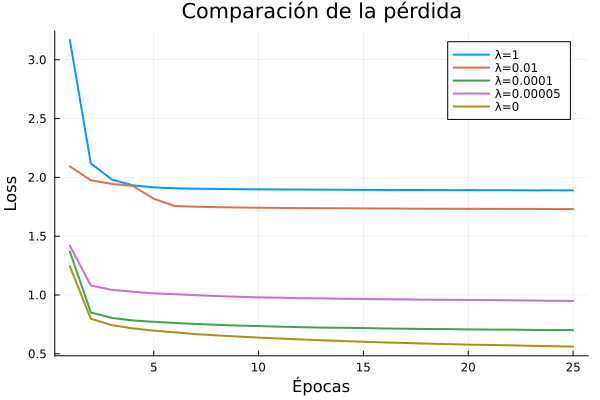

In [39]:
epochs = 1:25

plot(epochs, modelo1[2], label="λ=1 ", lw=2)
plot!(epochs, modelo2[2], label="λ=0.01 ", lw=2)
plot!(epochs, modelo3[2], label="λ=0.0001 ", lw=2)
plot!(epochs, modelo4[2], label="λ=0.00005 ", lw=2)
plot!(epochs, modelo5[2], label="λ=0 ", lw=2)
xlabel!("Épocas")
ylabel!("Loss")
title!("Comparación de la pérdida")

Ahora veamos el accuracy a través de las épocas:

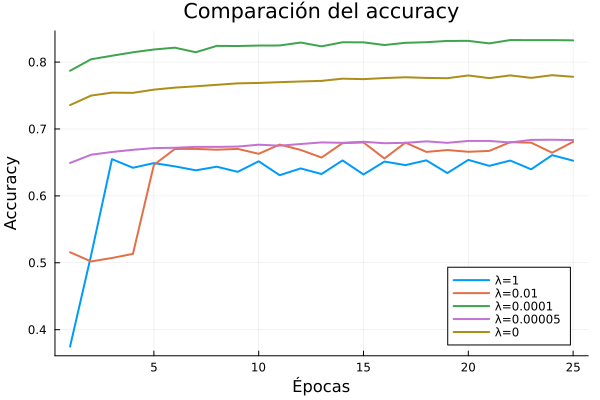

In [40]:
epochs = 1:25

plot(epochs, modelo1[3], label="λ=1 ", lw=2)
plot!(epochs, modelo2[3], label="λ=0.01 ", lw=2)
plot!(epochs, modelo3[3], label="λ=0.0001 ", lw=2)
plot!(epochs, modelo4[3], label="λ=0.00005 ", lw=2)
plot!(epochs, modelo5[3], label="λ=0 ", lw=2)
xlabel!("Épocas")
ylabel!("Accuracy")
title!("Comparación del accuracy")

Y finalmente el tiempo de ejecución por época:

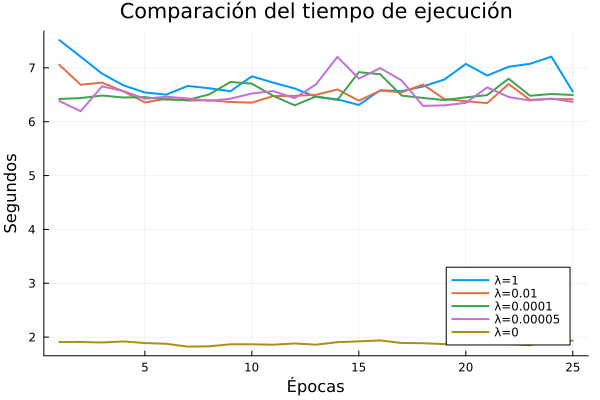

In [42]:
epochs = 1:25

plot(epochs, modelo1[4], label="λ=1 ", lw=2)
plot!(epochs, modelo2[4], label="λ=0.01 ", lw=2)
plot!(epochs, modelo3[4], label="λ=0.0001 ", lw=2)
plot!(epochs, modelo4[4], label="λ=0.00005 ", lw=2)
plot!(epochs, modelo5[4], label="λ=0 ", lw=2)
xlabel!("Épocas")
ylabel!("Segundos")
title!("Comparación del tiempo de ejecución")

El objetivo de los modelos es poder generalizar. Ahora veamos las predicciones hechas a los datos de testeo:

In [62]:
## Código generado por DeepSeek ##

function evaluateTest(model_tuple)
    model = model_tuple[1]
    test_loss = 0.0f0
    correct = 0
    total = 0
    times = Float32[]
        
    # Evaluación por batch
    for (x, y) in test_loader
        t_start = time()
        y_pred = model(x)
        push!(times, Float32(time() - t_start))
            
        test_loss += total_loss(x, y, 0.0f0, model, Flux.params(model))  # λ=0 en test
        correct += sum(onecold(y_pred) .== onecold(y))
        total += size(y, 2)
    end
    accuracy = correct / total
    loss = test_loss / total
    avg_inference_time = mean(times)
    
    return accuracy, loss, avg_inference_time
end


evaluateTest (generic function with 1 method)

Así podemos ver las predicciones de los modelos:

In [67]:
accM1, losM1, timM1 = evaluateTest(modelo1)
accM2, losM2, timM2 = evaluateTest(modelo2)
accM3, losM3, timM3 = evaluateTest(modelo3)
accM4, losM4, timM4 = evaluateTest(modelo4)
accM5, losM5, timM5 = evaluateTest(modelo5)

lossM1= round(losM1,digits=5)
timM1 = round(timM1,digits=5)
lossM2= round(losM2,digits=5)
timM2 = round(timM2,digits=5)
lossM3= round(losM3,digits=5)
timM3 = round(timM3,digits=5)
lossM4= round(losM4,digits=5)
timM4 = round(timM4,digits=5)
lossM5= round(losM5,digits=5)
timM5 = round(timM5,digits=5)

println("Para el modelo con λ=1 se obtiene un accuracy de $accM1 , una pérdida del $lossM1 y un tiempo promedio de $timM1")
println("Para el modelo con λ=0.01 se obtiene un accuracy de $accM2 , una pérdida del $lossM2 y un tiempo promedio de $timM2")
println("Para el modelo con λ=0.0001 se obtiene un accuracy de $accM3 , una pérdida del $lossM3 y un tiempo promedio de $timM3")
println("Para el modelo con λ=0.00005 se obtiene un accuracy de $accM4 , una pérdida del $lossM4 y un tiempo promedio de $timM4")
println("Para el modelo con λ=0 se obtiene un accuracy de $accM5 , una pérdida del $lossM5 y un tiempo promedio de $timM5")

Para el modelo con λ=1 se obtiene un accuracy de 0.6526 , una pérdida del 0.01481 y un tiempo promedio de 0.00162
Para el modelo con λ=0.01 se obtiene un accuracy de 0.6808 , una pérdida del 0.01247 y un tiempo promedio de 0.00141
Para el modelo con λ=0.0001 se obtiene un accuracy de 0.8325 , una pérdida del 0.00426 y un tiempo promedio de 0.00147
Para el modelo con λ=0.00005 se obtiene un accuracy de 0.6835 , una pérdida del 0.00678 y un tiempo promedio de 0.00147
Para el modelo con λ=0 se obtiene un accuracy de 0.778 , una pérdida del 0.00463 y un tiempo promedio de 0.00148


#### Conclusiones
*  Con los resultados obtenidos podemos concluir que este método de ortogonalización parece mejorar en generalización un modelo simple. Sin embargo, el valor del coeficiente $\lambda$ es bastante importante y su elección al momento de diseñar el modelo parece tener una importancia tan grande como la elección del learning-rate; tan solo el modelo con $\lambda=0.0001$ obtuvo mejores resultados, tanto en entrenamiento como en testeo, que el modelo con $\lambda=0$, es decir, el modelo sin regularización ortogonal.
*  El modelo simple fue bastante más rápido en el entrenamiento en comparación con el resto de modelos, la evidencia indica que el cálculo de la regularización (que es en lo que diferencia los entrenamientos) aumenta de forma considerable el tiempo de cómputo.

### Análisis Numérico
Ahora bien, al momento de entrenar el modelo también hemos obtenido otros dos datos por modelo. En partícular vamos a evaluar:
*  Estabilidad numérica, evaluando el error de ortogonalidad de las capas.
*  Condicionamiento de las matrices, evaluando el número de condición de las matrices:

$$\kappa(W) = \frac{ \sigma_{max}(W) }{ \sigma_{min}(W) } $$


Primero veamos la estabilidad númerica de cada capa por época.

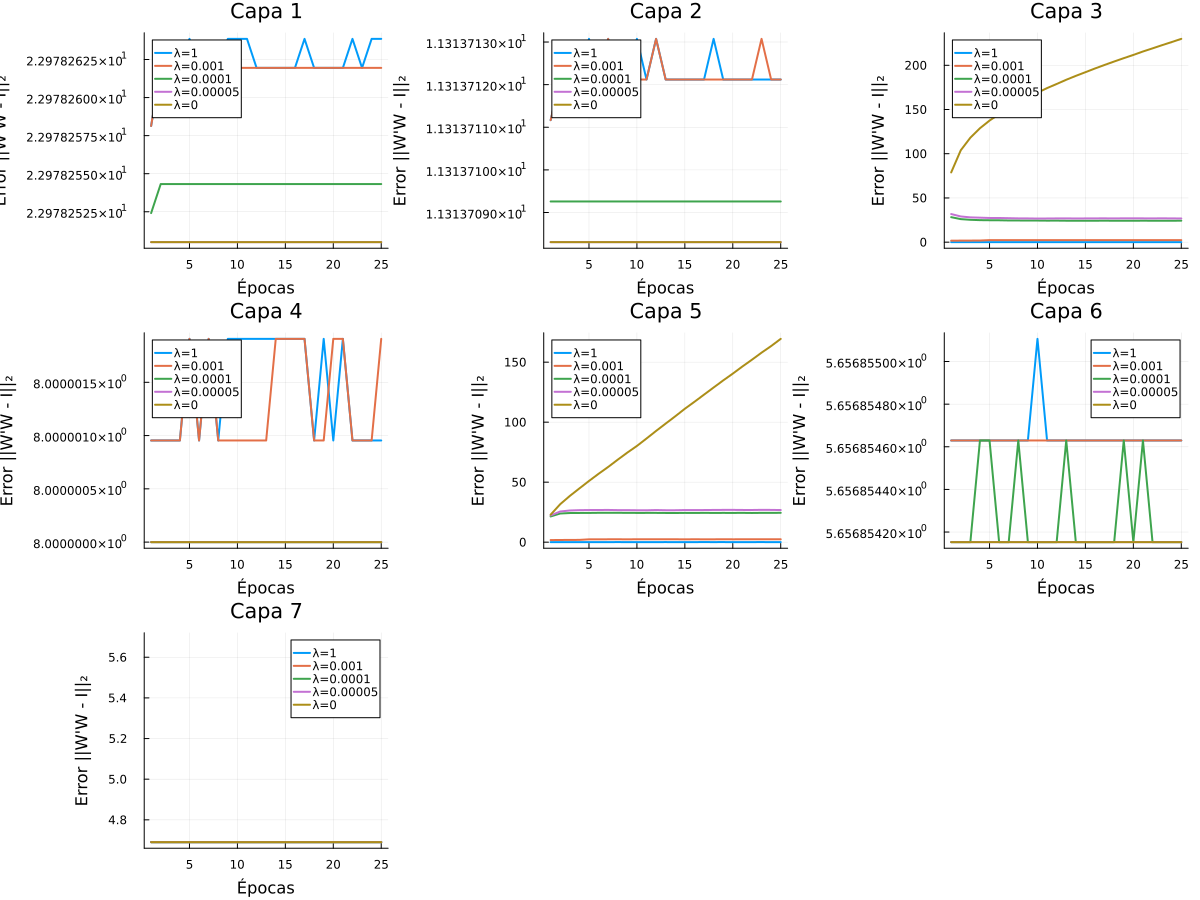

In [68]:
## Código generado por DeepSeek ##

epochs = 1:25
modelos = [modelo1, modelo2, modelo3, modelo4, modelo5]
λ_labels = ["λ=1", "λ=0.001", "λ=0.0001", "λ=0.00005", "λ=0"]

# Crear todas las gráficas de una vez
plots_array = []
for layer in 1:7
    p = plot(title="Capa $layer", xlabel="Épocas", ylabel="Error ||W'W - I||₂")
    
    for (modelo, label) in zip(modelos, λ_labels)
        layer_errors = [epoch_errors[layer] for epoch_errors in modelo[5]]
        plot!(p, epochs, layer_errors, label=label, lw=2)
    end
    
    push!(plots_array, p)
end

# Mostrar en un grid 3x3
plot(plots_array..., layout=(3, 3), size=(1200, 900))

Como se puede evidenciar, en todas las capas menos en la 3 y 5, el error de la ortogonalidad se mantiene en valores relativamente bajos en todos los modelos. Sin embargo, en las capas 3 y 5 el modelo no ortogonal parece explotar y en los modelos $\lambda=10^{-4}$ y $\lambda=10^{-5}$ el error es más elevado que en el resto de modelos.

Ahora veamos la condición de las matrices con los valores singulares:

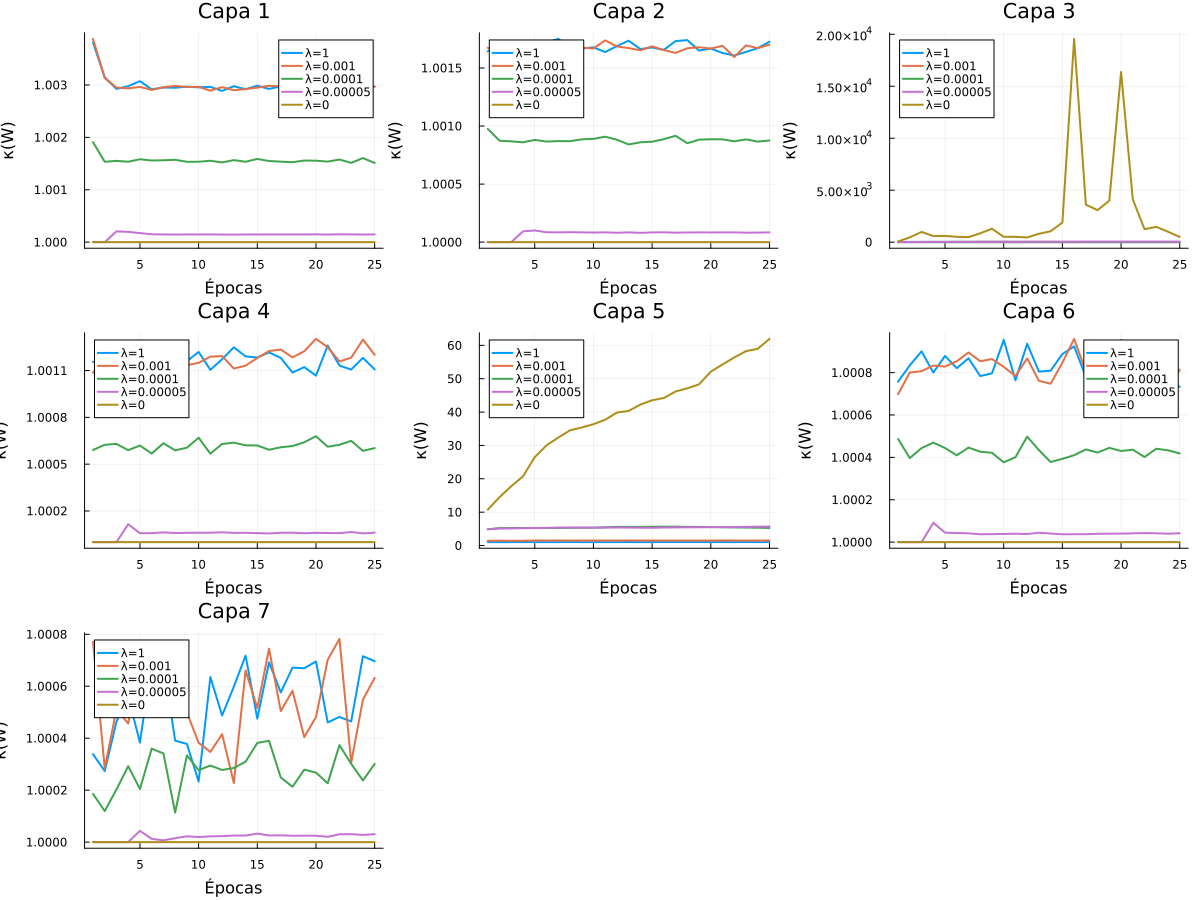

In [69]:
## Código generado por DeepSeek ##

epochs = 1:25
# Crear todas las gráficas de una vez
plots_array = []
for layer in 1:7
    p = plot(title="Capa $layer", xlabel="Épocas", ylabel="κ(W)")
    
    for (modelo, label) in zip(modelos, λ_labels)
        layer_errors = [epoch_errors[layer] for epoch_errors in modelo[6]]
        plot!(p, epochs, layer_errors, label=label, lw=2)
    end
    
    push!(plots_array, p)
end

# Mostrar en un grid 3x3
plot(plots_array..., layout=(3, 3), size=(1200, 900))

Aquí podemos observar un comportamiento similar, mientras que en los modelos ortogonales, en todas las capas parece mantenerse valores singulares similares, es decir, el número de condición es casi 1, en el modelo no ortogonal en las capas 3 y 5 no sucede esto. En particular, en la capa 5, mientras más épocas pasan estos valores parecen explotar cada vez más.

De los últimos dos experimentos podemos notar que las capas en donde el modelo sin ortogonalización explota en el error de ortogonalización son capas con matrices cuadradas: la capa 3 tenemos una matriz de tamaño $(128,128)$ y la capa 5 de tamaño $(64,64)$. 

Finalmente midamos el tiempo de ejecución del entrenamiento y el error de ortogonalidad por capas para una selección $\lambda=0.0001$ y $\lambda=0$, que dieron los mejores resultados en los experimentos anteriores, para matrices que se hacen cada vez más grandes. Para así observar el comportamiento asintótico del tiempo y de la estabilidad numérica. 

Para esto modifiquemos un poco las funciones que teníamos antes:

In [76]:
function createDinamicModel(numLayers = 3)
    layers = []
    push!(layers,Flux.flatten)
    push!(layers,OrthogonalDense(784,256))
    push!(layers,OrthogonalDense(256,128))
    for _ in 1:numLayers
        push!(layers,OrthogonalDense(128,128))
    end
    push!(layers,OrthogonalDense(128,64))
    push!(layers,OrthogonalDense(64,10))
    push!(layers,softmax)

    model = Chain(layers...)
    return model
end

createDinamicModel (generic function with 2 methods)

In [72]:
## Código generado parcialmente por Claude.ai como extensión de un código anterior ## 

function experimento2(λ = 1e-4, numLayers=5)
    opt = Flux.Optimise.Adam(0.001) 
   
   # Métricas de aprendizaje
    losses = Float32[]
    accs = Float32[]
    times = Float32[]
    
    # Métricas numéricas (por capa ortogonal)
    orth_errors = Vector{Float32}[]  # Para cada capa en cada época

    modelo = createDinamicModel(numLayers)
    ps = Flux.params(modelo)

    # Obtener capas ortogonales
    orth_layers = [layer for layer in Flux.modules(modelo) if typeof(layer) <: Dense]
    
    # Loop de entrenamiento
    for epoch in 1:10
        epoch_loss = 0.0
        epoch_time = 0.0
        for (x, y) in train_loader
            t_start = time()
            gs = gradient(ps) do
                total_loss(x, y, λ, modelo, ps)
            end
            Flux.update!(opt, ps, gs)
            epoch_time += Float32(time() - t_start)
            epoch_loss += total_loss(x,y,λ,modelo,ps)
        end
        # Cálculo de métricas numéricas (tras la época)
        push!(orth_errors, Float32[norm(layer.weight' * layer.weight - I, 2) for layer in orth_layers])
        
        acc = accuracy(test_loader, modelo)
        push!(losses, epoch_loss / length(train_loader))
        push!(accs, acc)
        push!(times, epoch_time)
        if epoch % 5 == 0
            println("Epoch $epoch - Loss: $(losses[end]) - Accuracy: $(accs[end]) - Time Elapsed: $(times[end])")
        end
    end
    return modelo, losses, accs, times, orth_errors
end

experimento2 (generic function with 3 methods)

Ahora corramos los experimentos en redes neuronales con 6,10,14,18,22 y 26 capas.

In [78]:
modelosE1 = []
modelosE2 = []

for i in 4:4:22
    j = i+2
    println("Modelo ortogonal con $j capas iniciado a entrenar")
    push!(modelosE1,experimento2(1e-4,i))
    println("Modelo no ortogonal con $j capas iniciado a entrenar")
    push!(modelosE2,experimento2(0,i))
end

Modelo ortogonal con 6 capas iniciado a entrenar
Epoch 5 - Loss: 0.51986945 - Accuracy: 0.8447 - Time Elapsed: 8.436998
Epoch 10 - Loss: 0.46143043 - Accuracy: 0.8541 - Time Elapsed: 8.327
Modelo no ortogonal con 6 capas iniciado a entrenar


┌ Warning: Implicit gradients such as `gradient(f, ::Params)` are deprecated in Flux!
│ Please see the docs for new explicit form.
│   caller = experimento2(λ::Int64, numLayers::Int64) at In[72]:24
└ @ Main .\In[72]:24


Epoch 5 - Loss: 0.6205839 - Accuracy: 0.7608 - Time Elapsed: 2.8360002
Epoch 10 - Loss: 0.5556281 - Accuracy: 0.7693 - Time Elapsed: 2.7950027
Modelo ortogonal con 10 capas iniciado a entrenar
Epoch 5 - Loss: 0.45474416 - Accuracy: 0.8321 - Time Elapsed: 10.4730015
Epoch 10 - Loss: 0.40249884 - Accuracy: 0.8493 - Time Elapsed: 10.675998
Modelo no ortogonal con 10 capas iniciado a entrenar
Epoch 5 - Loss: 0.36378843 - Accuracy: 0.9345 - Time Elapsed: 4.1780024
Epoch 10 - Loss: 0.29474205 - Accuracy: 0.9488 - Time Elapsed: 4.288995
Modelo ortogonal con 14 capas iniciado a entrenar
Epoch 5 - Loss: 1.1922736 - Accuracy: 0.5741 - Time Elapsed: 14.5460005
Epoch 10 - Loss: 0.7970562 - Accuracy: 0.6729 - Time Elapsed: 13.93
Modelo no ortogonal con 14 capas iniciado a entrenar
Epoch 5 - Loss: 0.5915731 - Accuracy: 0.855 - Time Elapsed: 5.7629995
Epoch 10 - Loss: 0.52528054 - Accuracy: 0.8623 - Time Elapsed: 5.804001
Modelo ortogonal con 18 capas iniciado a entrenar
Epoch 5 - Loss: 0.5459046 - A

Ahora veamos los tiempos de ejecución en total tomado por cada modelo:

In [85]:
totalOrtogonal = 0
totalNormal = 0
tiemposOrtogonal = Float32[]
tiemposNormal = Float32[]

for i in 1:5
    totalOrtogonalCapa = sum(modelosE1[i][4])
    totalOrtogonal += totalOrtogonalCapa
    totalNormalCapa = sum(modelosE2[i][4])
    totalNormal += totalNormalCapa
    push!(tiemposOrtogonal, totalOrtogonalCapa)
    push!(tiemposNormal, totalNormalCapa)
end
println("Tiempo de ejecución completo en los modelos ortogonales: $totalOrtogonal")
println("Tiempo de ejecución completo en los modelos no ortogonales: $totalNormal")


Tiempo de ejecución completo en los modelos ortogonales: 711.842
Tiempo de ejecución completo en los modelos no ortogonales: 300.76


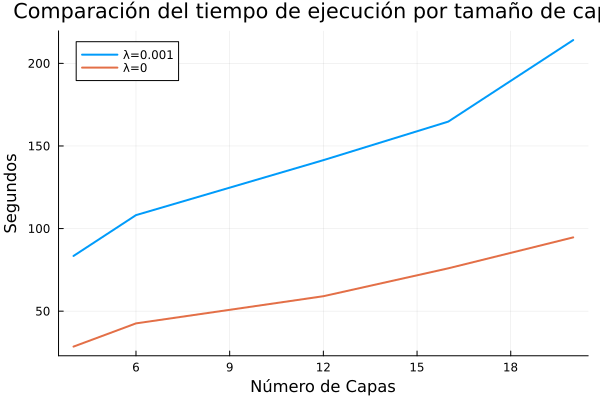

In [88]:
capas = [4,6,12,16,20]

plot(capas, tiemposOrtogonal, label="λ=0.001", lw=2)
plot!(capas, tiemposNormal, label="λ=0 ", lw=2)
xlabel!("Número de Capas")
ylabel!("Segundos")
title!("Comparación del tiempo de ejecución por tamaño de capas")

Podemos observar que claramente los modelos ortogonales tardan aproximadamente un poco más de el doble en ejecución. Sin embargo, no sabemos si esto es escalable, de momento, para redes neuronales con  pocas capas ambos modelos parecen tener un comportamiento asintótico lineal.

Ahora veamos el comportamiento en el error ortogonal:

In [90]:
totalOrtogonal = 0
totalNormal = 0
erroresOrtogonal = Float32[]
erroresNormal = Float32[]

for i in 1:5
    totalOrtogonalCapa = sum(sum(epoca) for epoca in modelosE1[i][5])
    totalOrtogonal += totalOrtogonalCapa
    totalNormalCapa = sum(sum(epoca) for epoca in modelosE2[i][5])
    totalNormal += totalNormalCapa
    push!(erroresOrtogonal, totalOrtogonalCapa)
    push!(erroresNormal, totalNormalCapa)
end
println("Error ortogonal completo en los modelos ortogonales: $totalOrtogonal")
println("Error ortogonal completo en los modelos no ortogonales: $totalNormal")


Error ortogonal completo en los modelos ortogonales: 6002.377
Error ortogonal completo en los modelos no ortogonales: 11465.414


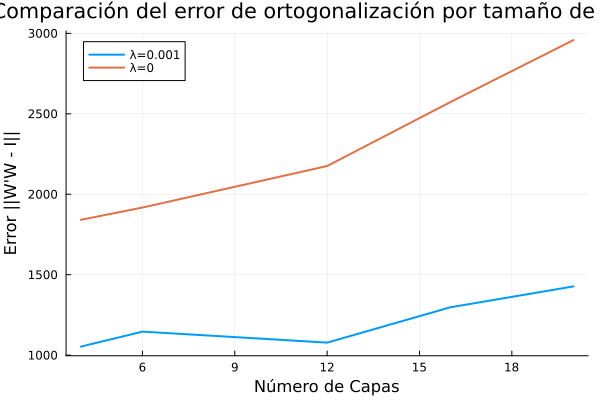

In [91]:
capas = [4,6,12,16,20]

plot(capas, erroresOrtogonal, label="λ=0.001", lw=2)
plot!(capas, erroresNormal, label="λ=0 ", lw=2)
xlabel!("Número de Capas")
ylabel!("Error ||W'W - I||")
title!("Comparación del error de ortogonalización por tamaño de capas")

Aquí podemos observar que en los modelos no ortogonales el error incrementa con un comportamiento asintóticamente lineal, mientras que los modelos ortogonales parecen mantenerse constantes, por lo menos en redes neuronales con pocas capas.

Anteriormente habíamos visto que en las matrices de pesos cuadradas, el error en los modelos no ortogonales explotaban. Veamos que sucede en las capas intermedias de los modelos no ortogonales:

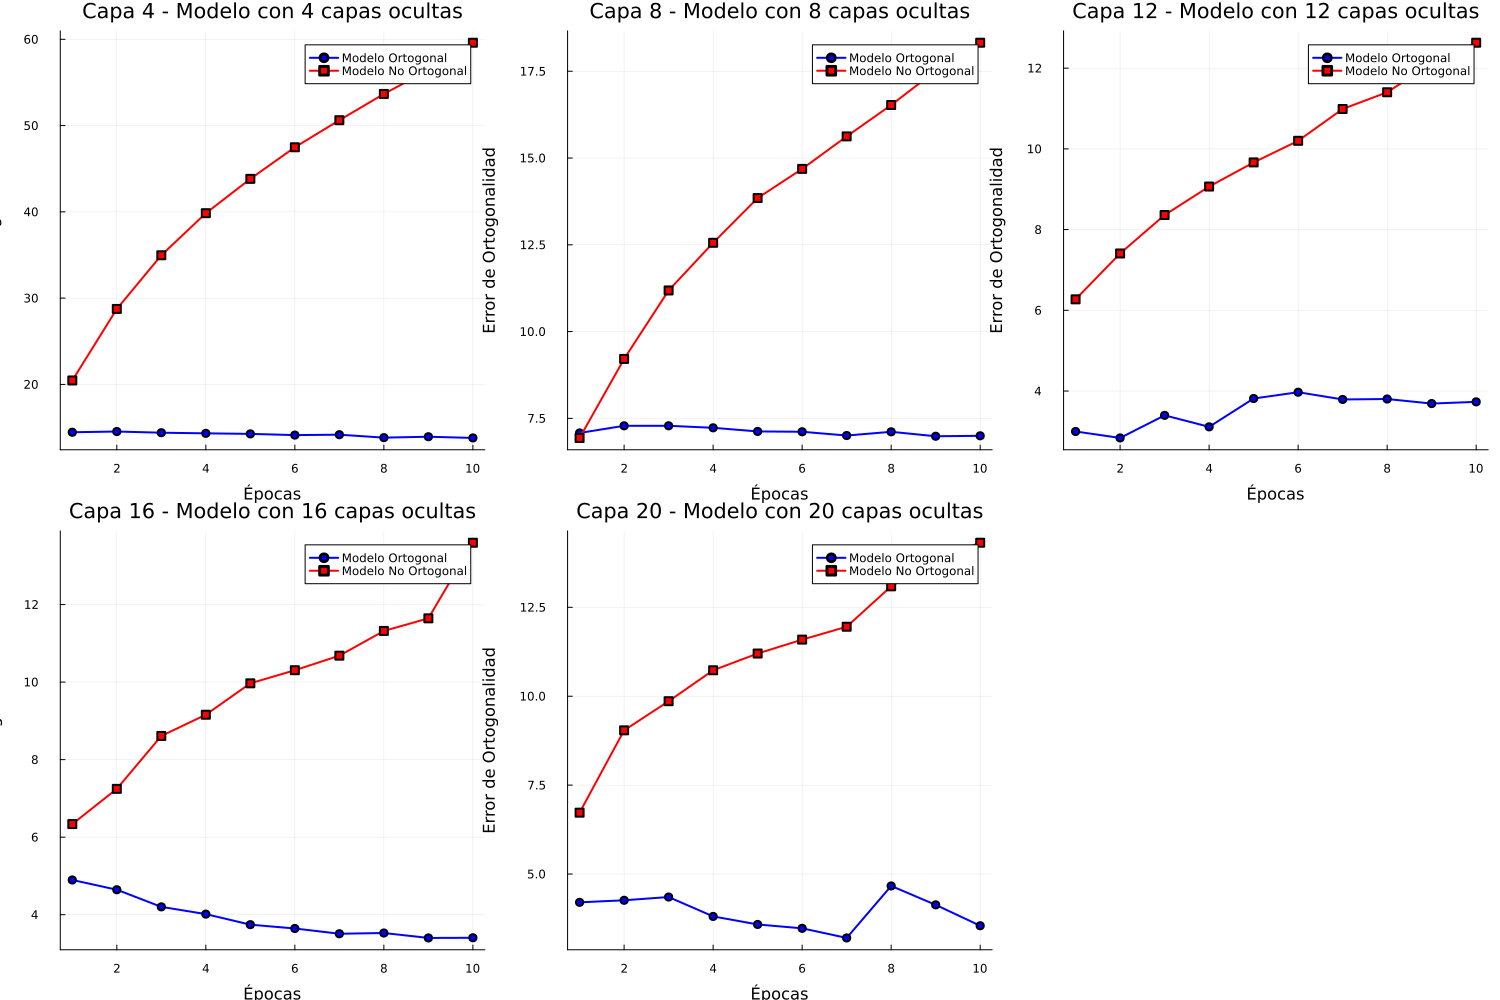

In [96]:
## Código generado por Claude.ai ##

epochs = 1:10  # Según tu función experimento2 entrena por 10 épocas
tamaños_red = [4, 8, 12, 16, 20]  # Los tamaños que usaste
plots_array = []

for i in 1:5
    # Determinar qué capa graficar (la capa intermedia de cada modelo)
    # Para un modelo con n capas ocultas, la capa intermedia sería aproximadamente n/2
    capa_a_graficar = tamaños_red[i]
    
    # Crear el plot para este par de modelos
    p = plot(title="Capa $capa_a_graficar - Modelo con $(tamaños_red[i]) capas ocultas", 
             xlabel="Épocas", 
             ylabel="Error de Ortogonalidad",
             legend=:topright)
    
    # Extraer errores de la capa específica para el modelo ortogonal
    errores_ortogonal = [epoch_errors[capa_a_graficar] for epoch_errors in modelosE1[i][5]]
    plot!(p, epochs, errores_ortogonal, 
          label="Modelo Ortogonal", 
          color=:blue, 
          lw=2, 
          marker=:circle)
    
    # Extraer errores de la capa específica para el modelo no ortogonal
    errores_no_ortogonal = [epoch_errors[capa_a_graficar] for epoch_errors in modelosE2[i][5]]
    plot!(p, epochs, errores_no_ortogonal, 
          label="Modelo No Ortogonal", 
          color=:red, 
          lw=2, 
          marker=:square)
    
    push!(plots_array, p)
end
plot(plots_array..., layout=(2, 3), size=(1500, 1000))

Podemos ver que el error incrementa con respecto al número de épocas, sin embargo, esta vez no explotan como sucedía anteriormente, una razón para esto podría ser que aquí hemos entrenado con tan solo 10 épocas, mientras que antes hicimos 25.

#### Conclusiones
*  La ortogonalización sobre los pesos de las capas parecen mantener la estabilidad numérica al mantener el error bajo, sobre todo en capas cuya dimensión de entrada es igual a la dimensión de salida, es decir, matrices de pesos cuadradas, en donde los modelos no ortogonales parecen tener una inestabilidad que se propaga a lo largo de las épocas, por lo que cada vez se hace más grande.
*  Asimismo, el número de condición también es afectado en las capas con matrices de pesos cuadradas de los modelos no ortogonales.
*  El tiempo de ejecución de los modelos ortogonales es mayor en comparación a los tiempos de los modelos no ortogonales. Sin embargo, por lo menos en redes neuronales con un número pequeño de capas $<50$, el crecimiento del tiempo en ambos modelos es lineal.

## **Conclusiones finales**

El uso de ortogonalización en las redes neuronales trae un interesante marco para desarrollar nuevas arquitecturas en tareas de clasificación. Los experimentos desarrollados permiten dar cuenta de que, a pesar de que en la teoría todo parece funcionar bien, en la práctica, las redes neuronales suelen ser muy sensibles a diversos tópicos que las envuelven. Lo que sugiere que no siempre lo teórico funciona mejor, probablemente porque aún hay demasiadas cosas que faltan por formalizar y que pueden guiar a unos mejores resultados. Así podemos concluir
*  La ortogonalización puede ayudar en el problema de generalización, sin embargo, por lo menos su aplicación en regularización, depende mucho del hiperparámetro $\lambda$ que escojamos; la elección de este hiperparámetro parece ser casi tan importante como la elección del learning-rate.
*  Aunque los experimentos muestran que no parece haber una escalabilidad tan grande en algunos aspectos importantes como el tiempo de entrenamiento, en el mundo real, los modelos pueden tener cientos de millones de parámetros distribuídas en cientas de capas. Por cuestión de poder de cómputo, aquí no hemos hecho experimentos a dichos niveles, sin embargo, todo parece indicar que estas diferencias se hacen más grandes y más críticas al escalar a niveles tan grandes.
*  Personalmente, creería que el uso de estas redes, más en particular de estas capas, debería limitarse y usarse solo en ciertos casos dependiendo del problema. Como ya se dijo anteriormente, computacionalmente no creo que valga la pena utilizar toda una red ortogonal, sobre todo teniendo otros métodos para generalizar, que aunque no tengan un marco teórico tan fuerte como estas redes, en la práctica funcionan bastante bien.

### **Sobre el uso de IA**
En el presente trabajo se han utilizado los siguientes modelos generadores de lenguaje: *ChatGPT*, *DeepSeek* y *Claude*. Tanto como para tener un plan de organización del trabajo, como para desarrollar los códigos que están mencionados.

# **Referencias**

* [1] S. Li, K. Jia, Y. Wen, T. Liu and D. Tao, "Orthogonal Deep Neural Networks," in *IEEE Transactions on Pattern Analysis and Machine Intelligence*, vol. 43, no. 4, pp. 1352-1368, 1 April 2021, doi: 10.1109/TPAMI.2019.2948352.

* [2] Simon J.D. Prince, "Understanding Deep Learning," *The MIT Press*, 2023.